In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

C:\Users\Jelle Gortemaker\AppData\Local\Temp\ipykernel_15520\1842678374.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  out = pairs.resample(freq).apply(_agg)
C:\Users\Jelle Gortemaker\AppData\Local\Temp\ipykernel_15520\1842678374.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  out = pairs.resample(freq).apply(_agg)


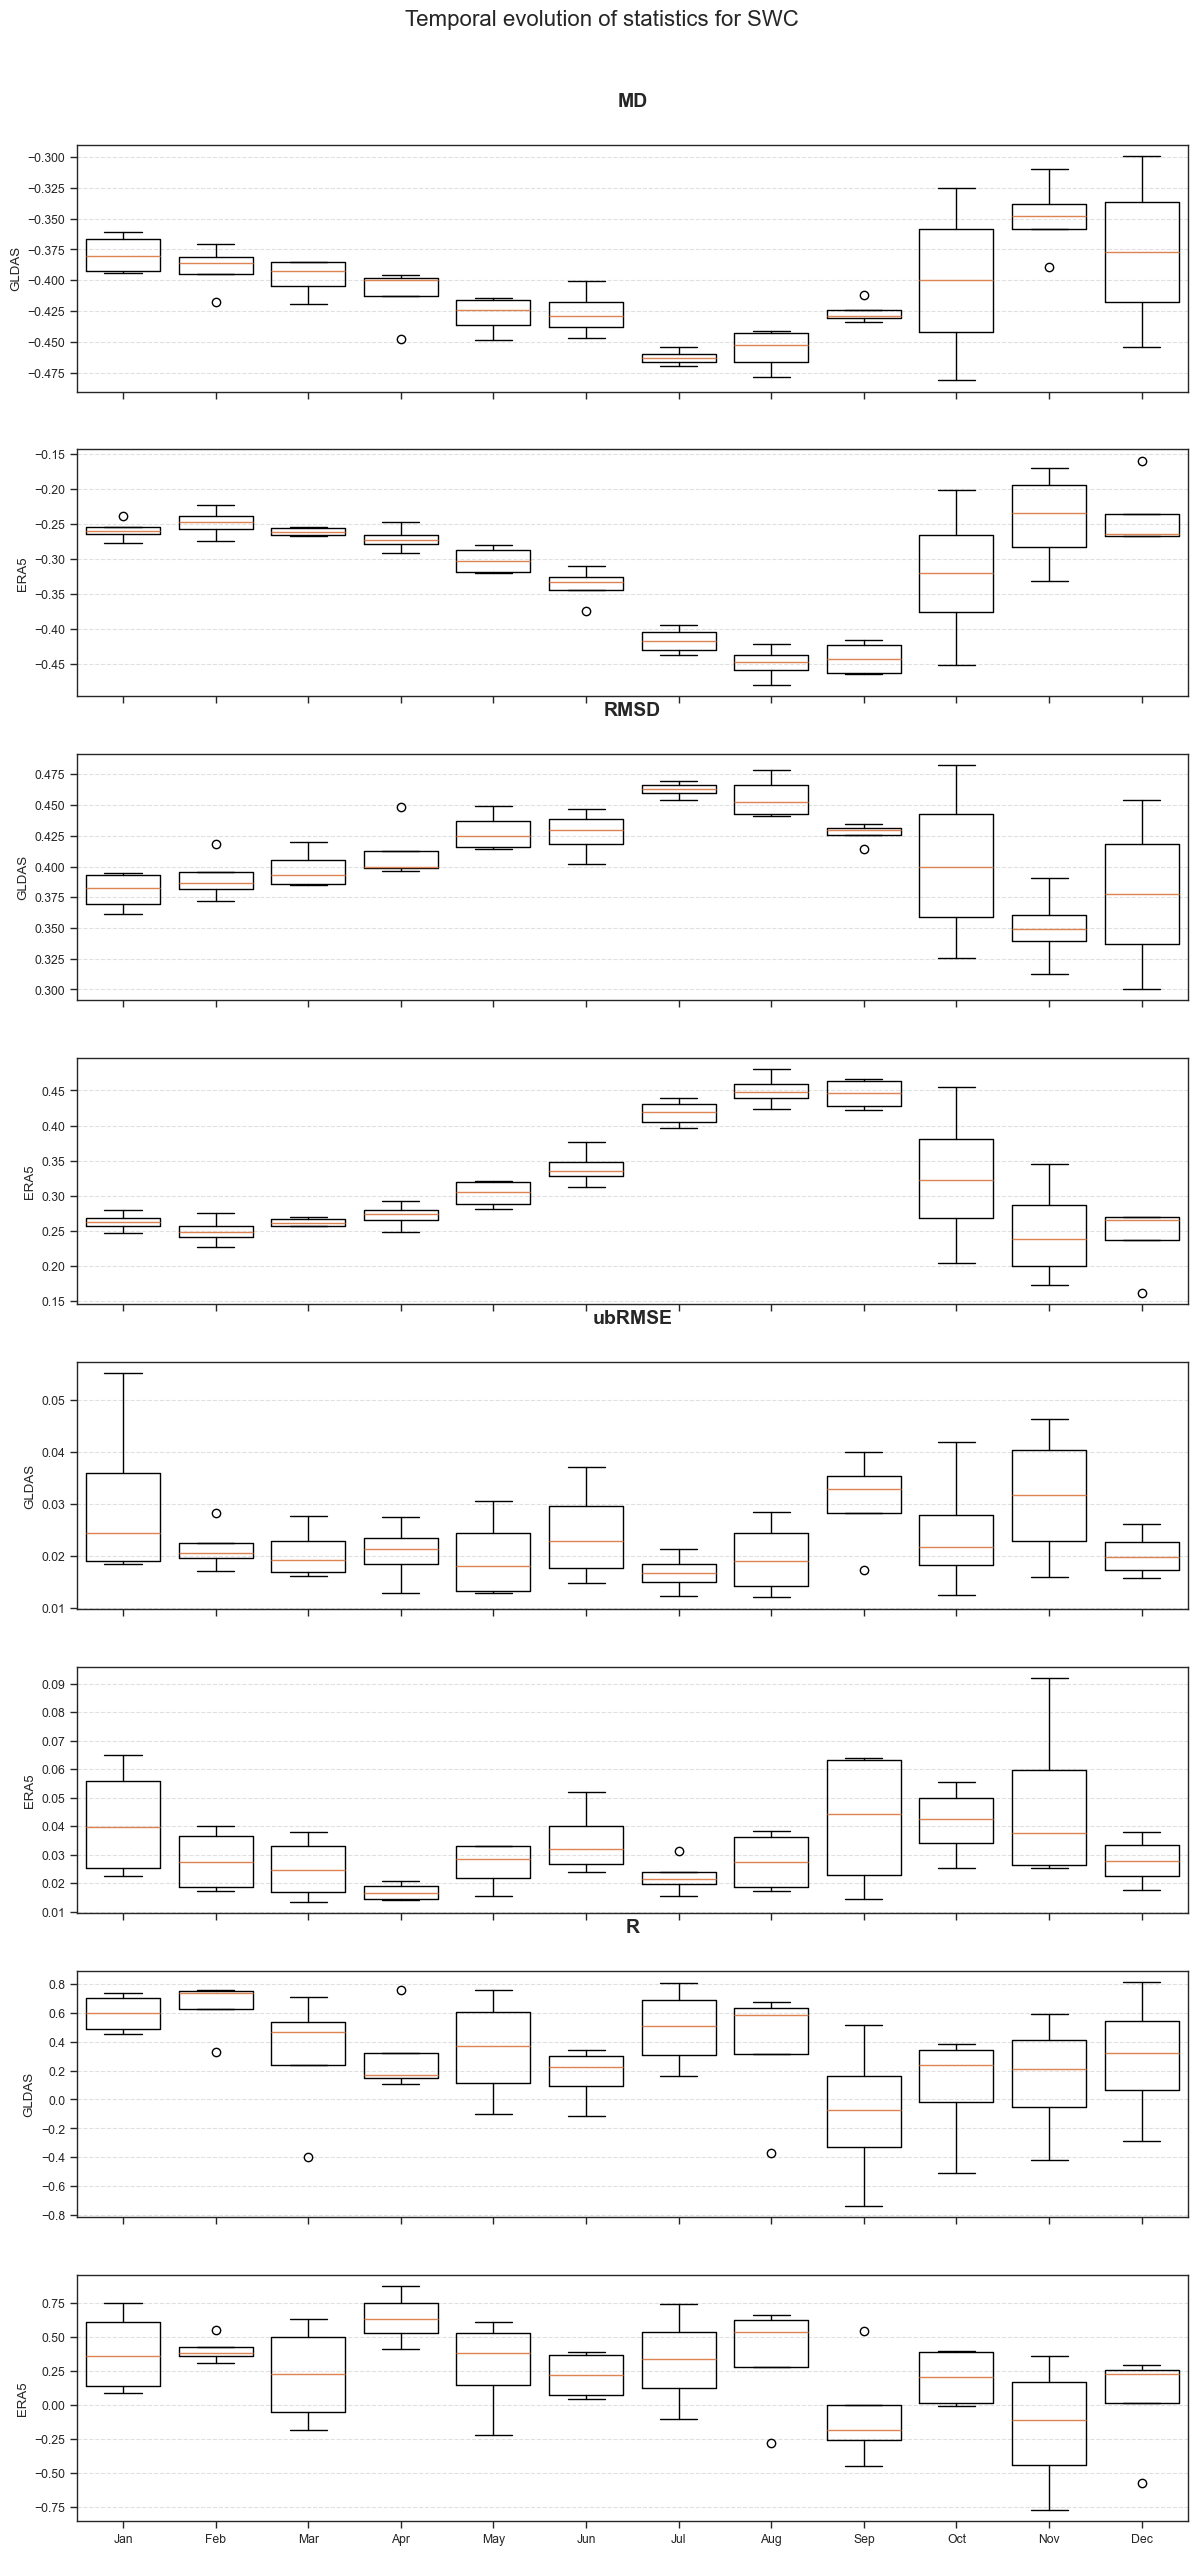

In [ ]:
# Optional (nice) style
sb.set_theme(style="ticks")
sb.set_context("paper")


# ---------------------------
# Core metrics (same as your flow)
# ---------------------------
def _four_stats_on_arrays(sat: np.ndarray, ref: np.ndarray) -> pd.Series:
    """
    Compute MD, RMSD, ubRMSE, Pearson R for two aligned arrays.
    """
    m = np.isfinite(sat) & np.isfinite(ref)
    sat, ref = sat[m], ref[m]
    if sat.size == 0:
        return pd.Series({"MD": np.nan, "RMSD": np.nan, "ubRMSE": np.nan, "R": np.nan})

    diff = sat - ref
    md = float(np.mean(diff))
    rmsd = float(np.sqrt(np.mean(diff**2)))
    ubrmse = float(np.sqrt(max(rmsd**2 - md**2, 0.0)))
    r = np.nan
    if sat.size > 1:
        try:
            r, _ = pearsonr(sat, ref)
        except Exception:
            r = np.nan
    return pd.Series({"MD": md, "RMSD": rmsd, "ubRMSE": ubrmse, "R": r})


def _four_stats_timegrouped(pairs: pd.DataFrame, freq: str = "M") -> pd.DataFrame:
    """
    pairs: DataFrame with columns ['sat','ref'] and a DatetimeIndex.
    Returns per-period stats DataFrame indexed by period end.
    """
    pairs = pairs.copy()
    pairs = pairs[np.isfinite(pairs["sat"]) & np.isfinite(pairs["ref"])]
    if pairs.empty:
        return pd.DataFrame(columns=["MD", "RMSD", "ubRMSE", "R"])

    def _agg(grp):
        return _four_stats_on_arrays(grp["sat"].to_numpy(), grp["ref"].to_numpy())

    out = pairs.resample(freq).apply(_agg)
    # flatten potential MultiIndex from .apply
    if isinstance(out.columns, pd.MultiIndex):
        out.columns = out.columns.get_level_values(-1)
    return out[["MD", "RMSD", "ubRMSE", "R"]]


# ---------------------------
# High-level API
# ---------------------------
def compute_satellite_stats(
    df: pd.DataFrame,
    date_col: str | None = None,    # if None -> first column
    ref_col: str | None = None,     # if None -> second column
    freq: str = "M",                # 'M' = month-end, 'MS' = month-start, 'D', 'Y', etc.
) -> dict[str, pd.DataFrame]:
    """
    Compute MD, RMSD, ubRMSE, R per period for each satellite vs the in-situ reference.

    Assumes the input DataFrame has columns:
      - first column: date
      - second column: in-situ (reference)
      - remaining columns: satellites (unknown names, arbitrary count)

    Parameters
    ----------
    df : pd.DataFrame
        Wide table with date + in-situ + satellites.
    date_col : str | None
        Name of date column. If None, uses the first column.
    ref_col : str | None
        Name of reference (in-situ) column. If None, uses the second column.
    freq : str
        Resampling frequency for period stats.

    Returns
    -------
    dict[str, pd.DataFrame]
        { satellite_name: stats_df } where stats_df has columns [MD, RMSD, ubRMSE, R]
        indexed by the resampled period end.
    """
    if date_col is None:
        date_col = df.columns[0]
    if ref_col is None:
        ref_col = df.columns[1]

    d = df.copy()
    # ensure datetime index
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col])
    d = d.set_index(date_col).sort_index()

    # coerce numeric
    d[ref_col] = pd.to_numeric(d[ref_col], errors="coerce")

    # satellites are everything except the reference
    sat_cols = [c for c in d.columns if c != ref_col]
    if not sat_cols:
        raise ValueError("No satellite columns found (columns beyond date and in-situ).")

    stats_by_sat: dict[str, pd.DataFrame] = {}
    for sat in sat_cols:
        pairs = pd.DataFrame({
            "sat": pd.to_numeric(d[sat], errors="coerce"),
            "ref": d[ref_col],
        }).dropna()
        stats_by_sat[sat] = _four_stats_timegrouped(pairs, freq=freq)

    return stats_by_sat


# ---------------------------
# Boxplots from the stats dict
# ---------------------------
def monthly_boxplots_from_stats_dict(
    stats_dict: dict[str, pd.DataFrame],
    cols: list[str] = ("MD", "RMSD", "ubRMSE", "R"),
    title: str = "",
    show_outliers: bool = True,
    figsize=(12, 25),
):
    """
    Create calendar-month boxplots for each metric and satellite.
    Adds a centered header for each metric block (e.g., 'MD', 'RMSD', etc.).
    """
    if not stats_dict:
        raise ValueError("stats_dict is empty.")

    satellites = list(stats_dict.keys())

    # Build one long table and standardize time index to monthly timestamps
    frames = []
    for sat in satellites:
        sdf = stats_dict[sat].copy()
        if isinstance(sdf.index, pd.PeriodIndex):
            sdf.index = sdf.index.to_timestamp()
        sdf["satellite"] = sat
        frames.append(sdf)
    long = pd.concat(frames).sort_index()

    nrows = len(cols) * len(satellites)
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=figsize, sharex=True)
    if nrows == 1:
        axes = [axes]

    month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    positions = list(range(1, 12+1))
    row = 0

    for i_stat, col in enumerate(cols):
        # index of the first row in this metric's block
        first_row_of_block = row

        for sat in satellites:
            ax = axes[row]; row += 1
            df_sat = long[long["satellite"] == sat].copy()

            # make sure index is month-end timestamps, then take month numbers
            idx = df_sat.index.to_period("M").to_timestamp()
            df_sat = df_sat.set_index(idx)

            if col not in df_sat.columns:
                ax.text(0.02, 0.5, f"Column '{col}' not in dataframe",
                        transform=ax.transAxes, ha="left", va="center", fontsize=10)
                ax.set_ylabel(sat)
                ax.grid(True, axis="y", linestyle="--", alpha=0.6)
                continue

            data = [df_sat.loc[df_sat.index.month == m, col].dropna().values
                    for m in range(1, 13)]

            ax.boxplot(
                data,
                positions=positions,
                widths=0.8,
                patch_artist=False,
                showfliers=show_outliers,
            )
            ax.set_ylabel(sat)
            ax.grid(True, axis="y", linestyle="--", alpha=0.6)

            # reasonable y-lims if there is data
            flat = np.concatenate([d for d in data if len(d) > 0]) \
                   if any(len(d)>0 for d in data) else np.array([])
            if flat.size:
                pad = 0.05 * (np.nanmax(flat) - np.nanmin(flat) + 1e-12)
                ax.set_ylim(np.nanmin(flat) - pad, np.nanmax(flat) + pad)

        # ---- Add the centered metric header above this block ----
        ax0 = axes[first_row_of_block]
        ax0.text(
            0.5, 1.14, col, transform=ax0.transAxes,
            ha="center", va="bottom", fontsize=14, fontweight="bold"
        )

    # bottom axis: month labels
    axes[-1].set_xticks(positions)
    axes[-1].set_xticklabels(month_labels)

    if title:
        fig.suptitle(title, y=1.02, fontsize=16)

    # a bit more vertical space to fit the per-metric headers
    plt.subplots_adjust(hspace=0.9)
    plt.tight_layout()
    plt.show()


# ---------------------------
# Example usage
# ---------------------------
# df_all: wide table where
#   df_all.columns[0] -> 'date'
#   df_all.columns[1] -> in-situ reference
#   df_all.columns[2:] -> satellites (unknown names, any count)
df_all = pd.read_csv(r"C:\Users\Jelle Gortemaker\OneDrive - Delft University of Technology\Documenten\0. MSc\MDP\Data\aligned_data.csv")  # replace with your data loading

stats = compute_satellite_stats(df_all, date_col=None, ref_col=None, freq="M")
monthly_boxplots_from_stats_dict(
    stats_dict=stats,
    cols=["MD","RMSD","ubRMSE","R"],
    title="Temporal evolution of statistics for SWC",
    show_outliers=True,
    figsize=(12, 25)
)
